In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Report numbers of each source

In [2]:
data = pd.read_csv("../../data/dataset_metadata.csv")

In [ ]:
pubs = data[~pd.isnull(data["DOI"])]

In [ ]:
online1 = data[pd.isnull(data["DOI"])]
online = online1[online1["Filename"].str.contains("Avi")]
online2 = online1[online1["Filename"].str.contains("orthumbr")]
# online = online[~online["Filename"].str.contains("olzano")]
# online = online[~online["URL (Video Name)"].str.contains("lotte")]

In [ ]:
label = [f[:3].lower() for f in online["Filename"]]
label2 = [f[:3].lower() for f in online2["Filename"]]
np.unique(label, return_counts = True), np.unique(label2, return_counts = True)

In [ ]:
len(pubs), np.unique(pubs["Type"], return_counts = True)

### Pathologies plot

In [3]:
def filter_fn(fn):
    if fn.lower() in ["reg", "cov", "pne", "vir"]:
        return fn.lower()
    else:
        print(fn)
        return "reg" # all wrong ones are reg write now
label = [filter_fn(fn[:3]) for fn in data["Filename"].values] #  if fn[:3] in ["Reg", "reg", "Cov", "cov", "pne", "Pne"]]

rec
rec
rec


In [3]:
data.columns

Index(['Date added', 'Current location', 'Filename', 'URL (Video Name)',
       'Label', 'Type', 'Probe', 'DOI', 'Source ID', 'Comments from web site',
       'Title', 'Comments first medical doctor (MD1)', 'MD2', 'MD3',
       'Framerate', 'Resolution', 'Length (frames)', 'Gender', 'Age',
       'Patient ID / Name', 'Lung /abdomen interface',
       'Preconditions / Comments about patient', 'Area according to DEGUM',
       'Unnamed: 23', 'Effusion', 'Consolidations', 'B-lines', 'A-lines',
       'Pleural line irregularities', 'Air bronchogram', 'Healthy', 'Fever',
       'Cough', 'Respiratory problems', 'Headache', 'Loss of smell/taste',
       'Fatigue', 'Sore throat', 'Asymptomatic'],
      dtype='object')

In [5]:
# effusion, consolidated, blines, alines, irregular = [], [], [], []
found_pattern = np.array(["(sub)pleural effusion", "consolidation", "B-line(s)", "A-lines", "irregular pleural line", "air bronchogram", "normal"])
pathologies = np.zeros((len(data), 7))
pat_dict = [["effusion"], ["consol"], ["b line", "b-line", "b - line"], ["a line", "a-line", "a - line"], 
            ["pleural irregular", "irregular pleural", "pleural thickening"], ["bronchogram"],
            ["normal", "healthy"]]

skipped = []
for i, row in data.iterrows():
    if "artifacts" in row["Current location"] or "uncertain" in row["Current location"] or  "not" in row["Current location"].lower():
        #  print("ueberspringe", row["Filename"])
        skipped.append(i)
        continue
    all_comments = (str(row['Comments first medical doctor (MD1)']) + " " +  str(row['MD2']) + " " +  str(row['Comments from web site'])).lower()
    # Effusion?
    for pat_ind in range(7):
        for pat in pat_dict[pat_ind]:
            if (not "no "+pat in all_comments) and (not "not "+ pat in all_comments) and pat in all_comments:
                pathologies[i,pat_ind] = 1
    # print(str(row['Comments first medical doctor (MD1)'])+ " " + str(row['MD2']))
    one_pathologies = np.where(pathologies[i]>0)[0]
    # print(found_pattern[one_pathologies])
    # print( row["Current location"])
    ## check abnormal healthy
    # if (row["Filename"]).lower()[:3]=="reg" and ("effusion" in all_comments or "consol" in all_comments or "pleural irregular" in all_comments):
    #    print(row["Filename"].lower())
    

In [6]:
filtered_pathologies = np.delete(pathologies, skipped, axis=0)
filtered_labels = np.delete(label, skipped)

In [7]:
mddf = pd.DataFrame(filtered_pathologies.astype(int), columns = found_pattern)

In [8]:
mddf.to_csv("../../data/pathologies.csv")

In [9]:
mddf["label"] = filtered_labels

In [10]:
overview = mddf.groupby("label").aggregate("mean")

In [11]:
overview.index[1]

'pne'

## Main plot

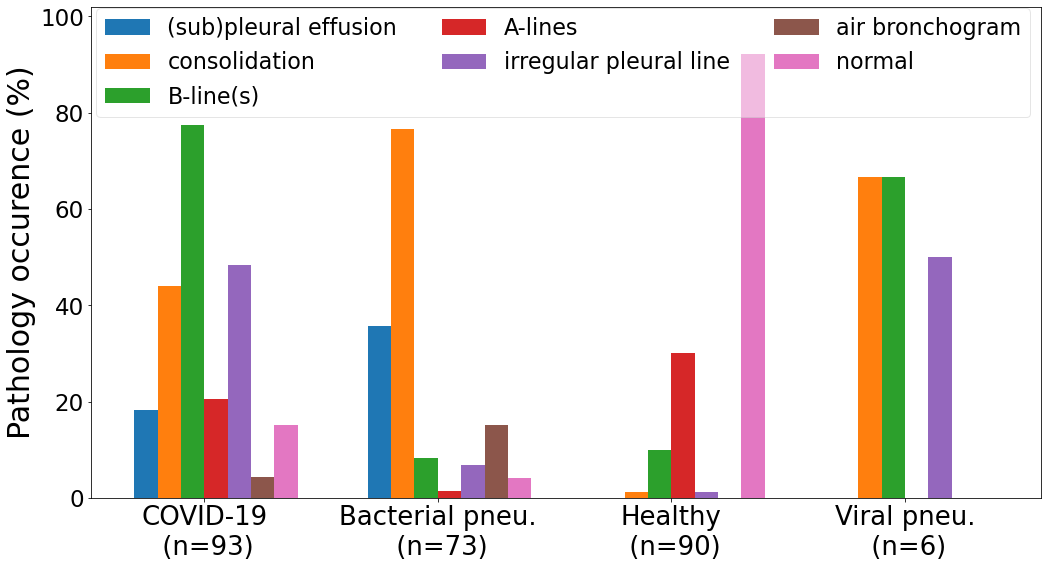

In [23]:
  # the label locations
width = 0.7  # the width of the bars
num = len(found_pattern)
x = np.arange(4)

uni, counts = np.unique(mddf["label"].values, return_counts=True)
xtick_labs = ["COVID-19", "Bacterial pneu.", "Healthy", "Viral pneu."]
new_xtick_labs = []
for i in range(4):
    new_xtick_labs.append(xtick_labs[i]+"\n (n="+str(int(counts[i]))+")")
    
fig, ax = plt.subplots(figsize=(15,8))

rects = list()
for i in range(num):
    rect = ax.bar(x - width/2 + (i+1)*width/num, overview[found_pattern[i]].values, width/num, label=found_pattern[i])
    rects.append(rect)
# rects2 = ax.bar(x + width/4, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pathology occurence (%)', fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(new_xtick_labs, fontsize=26,) #  rotation=5)
ax.legend(fontsize=22.2,loc='upper right', bbox_to_anchor=(1, 1.02), ncol=3, framealpha=0.5) # bbox_to_anchor=(0.25, 0.16, 0.81, 0.88)
ax.set_ylim(0,1.02)
ax.set_yticklabels(range(0,101, 20),fontsize=23)


fig.tight_layout()
plt.savefig("../../pocovidnet/results_oct/plots/pathologies.pdf")
plt.show()

##### 79/261

### Plot the other way round

In [ ]:
x = np.arange(len(overview.columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))

rects = list()
for i in range(4):
    rect = ax.bar(x - width/2 + i*width/4, overview.iloc[i].values, width/4, label=overview.index[i])
    rects.append(rect)
# rects2 = ax.bar(x + width/4, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Occurences in comments of medical experts', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(found_pattern, fontsize=20)
ax.legend(fontsize=20)
ax.set_ylim(0,0.8)

fig.tight_layout()

plt.show()

## Further analysis

In [ ]:
data.columns

In [14]:
fr = [float(fr) for fr in data_vids["Framerate"].values if fr is not None and ~np.isnan(float(fr))]
print("avg framerate", np.mean(fr), np.std(fr), np.min(fr), np.max(fr))

avg framerate 25.914728682170544 10.02247939102101 8.0 60.0


In [15]:
data_vids = data[data["Type"]=="video"]
print("Average number of frames and std")
np.nanmean(data_vids["Length (frames)"]), np.nanstd(data_vids["Length (frames)"])

Average number of frames and std


(159.64728682170542, 144.3462259906886)

In [ ]:
def not_nan(data):
    return np.array([d for d in data if not pd.isnull(d) and d!="n/A" and d!="nd"])
        

In [ ]:
notnan_ages = not_nan(data["Age"]).astype(int) # data[np.logical_and(~pd.isnull(data["Age"]), data["Age"]!="n/A")]
print("Age filled in for ", len(notnan_ages)/len(data), "% (len data:", len(data))
sns.distplot(notnan_ages)
plt.xlabel("Patient age", fontsize=15)
plt.yticks([])
plt.savefig("../results_oct/plots/age_dist.pdf")

In [ ]:
np.median(notnan_ages), np.mean(notnan_ages), np.std(notnan_ages)

In [ ]:
gender = not_nan(data["Gender"])
print("Gender filled in for", round(len(gender)/ len(data), 2), "%")
print(np.unique(gender, return_counts=True))
print(np.sum(gender=="m") / len(gender))

## Symptoms

In [15]:
symptom_cols = ['Current location', 'Fever','Cough', 'Respiratory problems', 'Headache', 'Fatigue', 'Asymptomatic']
# 'Sore throat', , 'Loss of smell/taste',
symptoms = data[symptom_cols]
# convert labels to int
labs_uni = list(np.unique(label))
label_int = [labs_uni.index(l) for l in label]
symptoms["label"] = label_int
symptoms = symptoms.dropna()
# drop all that have no symptom at all
symptoms = symptoms[symptoms["Fever"]!="n/A"]
symptoms = symptoms[~symptoms["Current location"].str.contains("not")]
symptoms = symptoms[~symptoms["Current location"].str.contains("Not")]
symptoms = symptoms[~symptoms["Current location"].str.contains("artifacts")]
# print(list(symptoms["Current location"]))
symptoms = symptoms.drop(columns=["Current location"])
symptom_cols = symptom_cols[1:]
for col in symptom_cols:
    symptoms.loc[symptoms[col]=="n/A", col] = 0
symptoms = symptoms.astype(int)
# symptoms = symptoms[cols].apply(pd.to_numeric)
# symptoms = symptoms.where(symptoms == "n/A", "0")


/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
len(symptoms) / len(filtered_pathologies)

0.3015267175572519

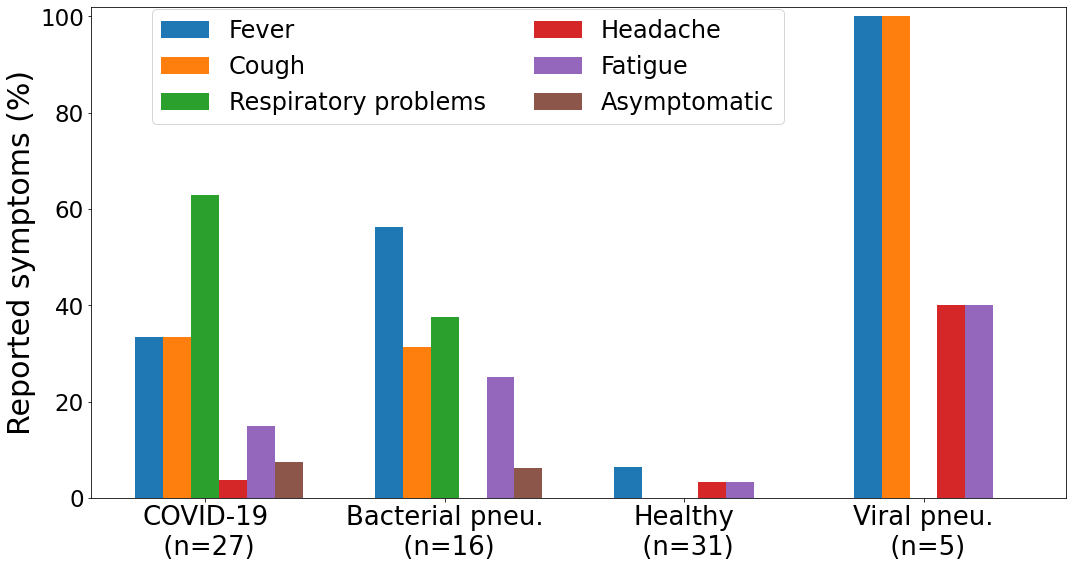

In [22]:
symptoms_grouped = symptoms.groupby("label").aggregate("mean")

uni, counts = np.unique(symptoms["label"].values, return_counts=True)
xtick_labs = ["COVID-19", "Bacterial pneu.", "Healthy", "Viral pneu."]
new_xtick_labs = []
for i in range(4):
    new_xtick_labs.append(xtick_labs[i]+"\n (n="+str(int(counts[i]))+")")

# the label locations
width = 0.7  # the width of the bars
num = len(symptom_cols)
x = np.arange(4)

fig, ax = plt.subplots(figsize=(15,8))

rects = list()
for i in range(num):
    rect = ax.bar(x - width/2 + (i+1)*width/num, symptoms_grouped[symptom_cols[i]].values, width/num, label=symptom_cols[i])
    rects.append(rect)
# rects2 = ax.bar(x + width/4, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reported symptoms (%)', fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(new_xtick_labs, fontsize=26)
ax.legend(fontsize=24, loc="upper left", bbox_to_anchor=(.05, 1.02), ncol=2)
ax.set_ylim(0,1.02)
ax.set_yticklabels(range(0,101, 20),fontsize=23)


fig.tight_layout()
plt.savefig("../../pocovidnet/results_oct/plots/symptoms.pdf")
plt.show()

In [ ]:
data_fever = (data["Fever"]=="1").astype(int) * (np.array(label_int)==2).astype(int) > 0
print(np.any(data_fever))
data[data_fever]
# np.logical_and(np.array(label_int)==2,  data["Respiratory problems"]==1)

### Avi's data:

In [ ]:
data.columns

In [158]:
avi = data[data["URL (Video Name)"].str.contains("humbria")]
# data[np.logical_or(data["Filename"].str.contains("Avi"), data["Filename"].str.contains("orthumbria"))]
avi_gender = avi[~pd.isnull(avi["Gender"])]
avi_gender = avi_gender[~avi_gender["Current location"].str.contains("not")]
avi_gender = avi_gender[~avi_gender["Current location"].str.contains("Not")]
avi_gender = avi_gender[~avi_gender["Current location"].str.contains("artifacts")]
np.unique(avi_gender["Type"], return_counts= True)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

## Get numbers of data

In [93]:
data.columns

Index(['Date added', 'Current location', 'Filename', 'URL (Video Name)',
       'Label', 'Type', 'Probe', 'DOI', 'Source ID', 'Comments from web site',
       'Title', 'Comments first medical doctor (MD1)', 'MD2', 'MD3',
       'Framerate', 'Resolution', 'Length (frames)', 'Gender', 'Age',
       'Patient ID / Name', 'Lung /abdomen interface',
       'Preconditions / Comments about patient', 'Area according to DEGUM',
       'Unnamed: 23', 'Effusion', 'Consolidations', 'B-lines', 'A-lines',
       'Pleural line irregularities', 'Air bronchogram', 'Healthy', 'Fever',
       'Cough', 'Respiratory problems', 'Headache', 'Loss of smell/taste',
       'Fatigue', 'Sore throat', 'Asymptomatic'],
      dtype='object')

In [97]:
dois = data["DOI"]
titles = data[~pd.isnull(dois)]
list(np.unique(titles["Title"]))

['A Preliminary Study on the Ultrasonic Manifestations of Peripulmonary Lesions of Non-Critical Novel Coronavirus Pneumonia (COVID-19)',
 'A proposed lung ultrasound and phenotypic algorithm for the care of COVID-19 patients with acute respiratory failure',
 'Advances in Point-of-Care Thoracic Ultrasound',
 'COVID-19 pneumonia manifestations at the admission on chest ultrasound, radiographs, and CT: single-center study and comprehensive radiologic literature review',
 'Clinical review: Bedside lung ultrasound in critical care practice',
 'Early recognition of the 2009 pandemic influenza A (H1N1) pneumonia by chest ultrasound',
 'Lung Ultrasound Can Influence the Clinical Treatment of Pregnant Women With COVID ‐19',
 'Lung Ultrasound in Community-Acquired Pneumonia and in Interstitial Lung Diseases',
 'Lung ultrasound for the diagnosis of community-acquired pneumonia in children',
 'Performance of chest ultrasound in pediatric pneumonia',
 'Point-of-Care Ultrasound in the Evaluation of 

In [98]:
data[data["Title"]=="Usefulness of lung ultrasound in diagnosing causes of exacerbation in patients with chronic dyspnea"]

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
272,21.05.2020,pocus_images/Convex,Reg_publication1.png,https://www.researchgate.net/publication/28779...,regular,Image,convex,10.5603/PiAP.a2015.0083,33.0,Single B-line in normal lung,...,0,0,0,0,0,0,0,0,0,0


In [154]:
data_image = data[data["Type"]=="image"]
data_image = data_image[data_image["URL (Video Name)"].str.contains("humbria")]
data_image = data_image[~data_image["Current location"].str.contains("not")]
data_image = data_image[~data_image["Current location"].str.contains("Not")]
data_image = data_image[~data_image["Current location"].str.contains("artifacts")]
data_image

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
131,22.07.2020,data/pocus_images/convex,Pneu_Avi_subpleural-consolidation.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
132,22.07.2020,data/pocus_images/convex,Reg_Avi_normal-A-lines-pleural-line.JPG,Data contributed by Northumbria Specialist Eme...,regular,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
137,22.07.2020,data/pocus_images/convex,Pneu_Avi_consolidated-lung-effusion-shred-sign...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
138,22.07.2020,data/pocus_images/convex,Reg_Avi_normal-A-lines.JPG,Data contributed by Northumbria Specialist Eme...,regular,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
139,22.07.2020,data/pocus_images/convex,Pneu_Avi_small-effusionA-line.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
140,22.07.2020,data/pocus_images/convex,Pneu_Avi_plerual-effusion-consolidated-lung.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
141,22.07.2020,data/pocus_images/convex,Pneu_Avi_hyperechoic-effusion.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
142,22.07.2020,data/pocus_images/convex,Pneu_Avi_B-lines-hyperechoic-effusion-consolid...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
143,22.07.2020,data/pocus_images/convex,Pneu_Avi_large-anaechoic-effusion-with-atelect...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
144,22.07.2020,data/pocus_images/convex,Pneu_Avi_consolidated-lung.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A


In [153]:
data_image = data[data["Type"]=="image"]
data_image[data["Probe"]=="convex"]
# 

/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
131,22.07.2020,data/pocus_images/convex,Pneu_Avi_subpleural-consolidation.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
132,22.07.2020,data/pocus_images/convex,Reg_Avi_normal-A-lines-pleural-line.JPG,Data contributed by Northumbria Specialist Eme...,regular,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
135,22.07.2020,data/data_with_artifacts,Reg_Avi_hyperechoic-effusion-mass-thickened-di...,Data contributed by Northumbria Specialist Eme...,regular,image,convex,NaN,18.0,"See filename, breast cancer patient",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
137,22.07.2020,data/pocus_images/convex,Pneu_Avi_consolidated-lung-effusion-shred-sign...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
138,22.07.2020,data/pocus_images/convex,Reg_Avi_normal-A-lines.JPG,Data contributed by Northumbria Specialist Eme...,regular,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
139,22.07.2020,data/pocus_images/convex,Pneu_Avi_small-effusionA-line.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
140,22.07.2020,data/pocus_images/convex,Pneu_Avi_plerual-effusion-consolidated-lung.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
141,22.07.2020,data/pocus_images/convex,Pneu_Avi_hyperechoic-effusion.JPG,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
142,22.07.2020,data/pocus_images/convex,Pneu_Avi_B-lines-hyperechoic-effusion-consolid...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
143,22.07.2020,data/pocus_images/convex,Pneu_Avi_large-anaechoic-effusion-with-atelect...,Data contributed by Northumbria Specialist Eme...,Bacterial pneumonia,image,convex,NaN,18.0,see filename,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A


In [151]:
# GET WEB VIDEOS
data_image = data[data["Type"]=="image"]
data_image = data_image[pd.isnull(data_image["DOI"])]
data_image = data_image[~data_image["Filename"].str.contains("Avi")]
data_image = data_image[~data_image["Filename"].str.contains("olzano")]
data_image = data_image[~data_image["Filename"].str.contains("orthumbria")]
data_image = data_image[~data_image["Current location"].str.contains("utterfly")]
data_image = data_image[~data_image["Current location"].str.contains("not")]
data_image = data_image[~data_image["Current location"].str.contains("Not")]
data_image = data_image[~data_image["Current location"].str.contains("artifacts")]
data_image = data_image[~data_image["URL (Video Name)"].str.contains("atlas")]
data_image = data_image[~data_image["URL (Video Name)"].str.contains("grepmed")]
data_image = data_image[~data_image["URL (Video Name)"].str.contains("litfl")]
data_image = data_image[~data_image["URL (Video Name)"].str.contains("charlotte")]
data_image
# data_image[~pd.isnull(data_image["DOI"])]

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
210,22.07.2020,data/pocus_images/convex,Cov_website_donation_2.jpeg,Website donation,COVID-19,image,convex,NaN,19.0,"Website donation, no comment",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
211,22.07.2020,data/pocus_images/convex,Cov_website_donation_3.jpeg,Website donation,COVID-19,image,convex,NaN,19.0,"Website donation, no comment",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
212,22.07.2020,data/pocus_images/linear,Cov_website_donation_1.png,Website donation,COVID-19,image,linear,NaN,19.0,"Website donation, no comment",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
282,21.05.2020,pocus_images/Convex,Reg_acutemedicine.png,https://www.acutemedicine.org.uk/wp-content/up...,regular,image,convex,NaN,37.0,simple and homogeneous and grey. It sits betwe...,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
284,21.05.2020,pocus_images/Convex,Cov_severe_acutemedicine.png,https://www.acutemedicine.org.uk/wp-content/up...,COVID-19,image,convex,NaN,37.0,"As the disease develops, the B line numbers in...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
285,21.05.2020,pocus_images/Linear,Cov_blines_acutemedicine.png,https://www.acutemedicine.org.uk/wp-content/up...,COVID-19,image,linear,NaN,37.0,"As the disease develops, the B line numbers in...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A


In [163]:
data_image = data[data["Type"]=="video"]
data_image= data_image[data_image["Probe"]=="linear"]
data_image = data_image[~data_image["Filename"].str.contains("olzano")]
data_image

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
36,20.04.2020,data/pocus_videos/Linear,Cov-Atlas-pleural.mp4,http://www.thepocusatlas.com/covid19-1/common-...,COVID-19,video,linear,NaN,2.0,Common pleural based findings in covid-19\r,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
37,20.04.2020,data/pocus_videos/Linear,Cov-Atlas-pleural2.mp4,http://www.thepocusatlas.com/covid19-1/pr8gk6t...,COVID-19,video,linear,NaN,2.0,Pleural findings in covid-19\r\n,...,0,0,0,0,1,0,0,0,0,0
62,20.04.2020,data/pocus_videos/Linear,Reg-grep-normal-alines-original.mp4,https://www.grepmed.com/images/7578,regular,video,linear,NaN,4.0,POCUS: Normal lung ultrasound. A-profile with ...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
63,20.04.2020,data/pocus_videos/Linear,Cov-grep-7500.mp4,https://www.grepmed.com/images/7500,regular,video,linear,NaN,4.0,Irregular pleural line with subpleural nodular...,...,0,0,0,0,1,0,0,0,0,0
64,20.04.2020,data/pocus_videos/Linear,Cov-grep-7432.mp4,https://www.grepmed.com/images/7432,COVID-19,video,linear,NaN,4.0,"Pt with COVID admitted with nearly normal EF, ...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
65,20.04.2020,data/pocus_videos/Linear,Cov-grep-7431.mp4,https://www.grepmed.com/images/7431,COVID-19,video,linear,NaN,4.0,"B lines, Subpleural consolidation, Air broncho...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
72,20.04.2020,data/pocus_videos/Linear,Reg-Youtube-start20sec.mp4,https://www.youtube.com/watch?v=Qd-26HdJP6I,regular,video,linear,NaN,10.0,NaN,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
73,20.04.2020,data/pocus_videos/Linear,Pneu-Youtube-start20sec.mp4,https://www.youtube.com/watch?v=Qd-26HdJP6I,Bacterial pneumonia,video,linear,NaN,10.0,NaN,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
74,20.04.2020,data/pocus_videos/Linear,Reg-Youtube-Video_902_Lung_POCUS-left.mp4,https://www.youtube.com/watch?v=HqPXJ0A0HCU,regular,video,linear,NaN,11.0,NaN,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
75,20.04.2020,data/pocus_videos/Linear,Reg-NormalLung.mp4,https://criticalcarenorthampton.com/thoracic-o...,regular,video,linear,NaN,12.0,NaN,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A


In [159]:
# GET publications videos and images
data_image = data[data["Type"]=="video"]
data_image = data_image[~pd.isnull(data_image["DOI"])]
data_image = data_image[~data_image["Current location"].str.contains("not")]
data_image = data_image[~data_image["Current location"].str.contains("Not")]
data_image = data_image[~data_image["Current location"].str.contains("artifacts")]
data_image

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
221,22.06.2020,pocus_videos/Convex,Reg_alines_advancesVid4.mp4,https://www.sciencedirect.com/science/article/...,regular,video,convex,https://doi.org/10.1016/j.emc.2015.09.003,21.0,"Video 4. A lines are bright, or hyperechoic, r...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
223,22.06.2020,pocus_videos/Convex,Vir_blines_advancesVid9.mp4,https://www.sciencedirect.com/science/article/...,Viral pneumonia,video,convex,https://doi.org/10.1016/j.emc.2015.09.003,21.0,Video 9: Numerous B lines are seen in this lun...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
224,22.06.2020,pocus_videos/Convex,Pneu_consol_advancesVid10.mp4,https://www.sciencedirect.com/science/article/...,Bacterial pneumonia,video,convex,https://doi.org/10.1016/j.emc.2015.09.003,21.0,Video 10. Densely consolidated right lung base...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
225,22.06.2020,pocus_videos/Convex,Reg_clinicalreview_mov1.mp4,https://link.springer.com/article/10.1186/cc56...,regular,video,convex,https://doi.org/10.1186/cc5668,22.0,An avi movie showing ultrasound pattern of nor...,...,0,1,NaN,n/A,n/A,n/A,n/A,n/A,n/A,n/A
226,22.06.2020,pocus_videos/Convex,Pneu_clinicalreview_MOV4.mp4,https://link.springer.com/article/10.1186/cc56...,Bacterial pneumonia,video,convex,https://doi.org/10.1186/cc5668,22.0,An avi movie showing a cephalocaudal view of c...,...,0,0,NaN,n/A,n/A,n/A,n/A,n/A,n/A,n/A
231,22.06.2020,pocus_videos/Convex,Vir_whitelung_h1n1.mp4,https://link.springer.com/article/10.1186/cc11201,Viral pneumonia,video,convex,https://doi.org/10.1186/cc11201,24.0,H1N1 infection - White lung. US pattern displ...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
232,22.06.2020,pocus_videos/Convex,Cov_new_pregnant_vid1.avi,https://onlinelibrary.wiley.com/doi/full/10.10...,COVID-19,video,convex,https://doi.org/10.1002/jum.15367,25.0,Normal LUS pattern with hyperechoic horizontal...,...,0,1,1,0,1,0,0,0,0,0
233,22.06.2020,pocus_videos/Convex,Cov_new_pregnant_vid2.avi,https://onlinelibrary.wiley.com/doi/full/10.10...,COVID-19,video,convex,https://doi.org/10.1002/jum.15367,25.0,Video 2 Abnormal LUS findings of a patient wit...,...,0,0,0,0,1,0,0,1,0,0
234,22.06.2020,pocus_videos/Convex,Cov_new_pregnant_vid3.avi,https://onlinelibrary.wiley.com/doi/full/10.10...,COVID-19,video,convex,https://doi.org/10.1002/jum.15367,25.0,Video 3 Lung US findings were classified as sc...,...,0,0,0,0,0,0,0,0,0,0
235,22.06.2020,pocus_videos/Convex,Cov_new_pregnant_vid4.avi,https://onlinelibrary.wiley.com/doi/full/10.10...,COVID-19,video,convex,https://doi.org/10.1002/jum.15367,25.0,Video 4 This video shows multiple discrete B‐l...,...,0,0,0,1,1,0,0,0,0,0


In [104]:
# get grep
data_notnan = data[~pd.isnull(data["URL (Video Name)"])]
data_notnan[data_notnan["URL (Video Name)"].str.contains("grep")]

,Date added,Current location,Filename,URL (Video Name),Label,Type,Probe,DOI,Source ID,Comments from web site,...,Air bronchogram,Healthy,Fever,Cough,Respiratory problems,Headache,Loss of smell/taste,Fatigue,Sore throat,Asymptomatic
42,20.04.2020,data/pocus_videos/Convex,Cov-grepmed-blines-pocus-.mp4,https://www.grepmed.com/images/7415,COVID-19,video,convex,NaN,4.0,Scanning COVID-19 everyday..but not all the B-...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
43,20.04.2020,data/pocus_videos/Convex,Cov-grepmed2.mp4,https://www.grepmed.com/images/7410,COVID-19,video,convex,NaN,4.0,Here’s an example from an intensivist caring f...,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
44,20.04.2020,data/pocus_videos/Convex,pneu-gred-6.gif,https://www.grepmed.com/images/5721/airbroncho...,Bacterial pneumonia,video,convex,NaN,4.0,"Haitian woman fever, cough & this clip => PNA ...",...,0,0,1,1,0,0,0,0,0,0
45,20.04.2020,data/pocus_videos/Convex,Pneu-grep-pneumonia1.mp4,https://www.grepmed.com/images/6903,Bacterial pneumonia,video,convex,NaN,4.0,Here there is consolidation in the distributio...,...,0,0,0,0,1,0,0,0,0,0
46,20.04.2020,data/pocus_videos/Convex,Pneu-grep-pneumonia2_1.mp4,https://www.grepmed.com/images/6876,Bacterial pneumonia,video,convex,NaN,4.0,"When lung looks like liver, it's never a good ...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
47,20.04.2020,data/pocus_videos/Convex,Pneu-grep-pneumonia4.mp4,https://www.grepmed.com/images/6431,Bacterial pneumonia,video,convex,NaN,4.0,"Pneumonia with irregular step ladder or ""shred...",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
48,20.04.2020,data/pocus_videos/Convex,pneu-gred-7.gif,https://www.grepmed.com/images/1304/airbroncho...,Bacterial pneumonia,video,convex,NaN,4.0,"Pneumonia with Air Bronchograms, Effusion",...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
49,20.04.2020,data/pocus_videos/Convex,Pneu-grep-pneumonia3.mp4,https://www.grepmed.com/images/6439,Bacterial pneumonia,video,convex,NaN,4.0,Pneumonia on Lung Ultrasound (POCUS),...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
50,20.04.2020,data/pocus_videos/Convex,Reg-Grep-Alines.mp4,https://www.grepmed.com/images/7408,regular,video,convex,NaN,4.0,Normal Pleural Lines on Lung Ultrasound,...,0,0,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
51,20.04.2020,data/pocus_videos/Convex,Reg-Grep-Normal.gif,https://www.grepmed.com/images/5325,regular,video,convex,NaN,4.0,Normal horizontal repetitive artifacts,...,0,1,n/A,n/A,n/A,n/A,n/A,n/A,n/A,n/A
